# Tutorial: Surface plot with BrainSpace  
__Content creators:__ Raul R Cruces, Davide Momi   
__pod name__: Truthful-inchworms 149

First we load the necessary libraries

In [1]:
#@title Import functions
%matplotlib inline  
!pip install brainspace --quiet
import ipywidgets as widgets  

# Interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # interactive display
my_layout = widgets.Layout()

import numpy as np
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres, plot_surf
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh import mesh_cluster
import panel as pn
pn.extension('vtk')
import os # OS to handle paths
import pandas as pd # pandas for data framse
import csv
import urllib.request as urllib2

import matplotlib.pyplot as plt # For changing the color maps
from matplotlib import cm # cm=colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from hcp_regions import HCPRegions
import ipywidgets as widgets       # interactive display


In [2]:
#@title Helper functions

"""
This function was copied from github.com/ansteeg, the original code can be found here:
     https://github.com/ansteeg/NeuroMatchProject

     It was modified in order to use it with surface plot from BrainSpace

"""

class HCPRegions:
    """
    Translates short region names into more information.
    Attributes:
        table_path(str): path to the hcp_parcels.csv file
        table(pd.DataFrame): the loaded table as a pandas dataframe
    From the paper (doi:10.1038/nature18933):
    "Table 1 lists the 180 areas of the cortical parcellation with index number, short name,
    description, whether or not the area is new or not, the sections the area is described in,
    synonyms or ‘quasi-synonyms’ for the area, and key studies used for the area’s
    identification. A “Yes” in the ‘New?’ column signifies an area that was not previously
    described in the neuroanatomical literature as far as we are aware. For some areas, “Yes*”
    signifies subdivisions of a previously described area, homologues, or similarity to a
    previously described area but not the same. “No” means that the area was previously
    described in a very similar form to what we found here. The bold section number is the
    primary section in which the area is described. Bold studies are those that had surfacemapped
    data available for us to make direct comparisons on the same atlas mesh."
    """

    table_path = 'https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/hcp_parcels.csv'
    table = None

    def __init__(self):
        """ Inits the HCPRegions class and loads the table from file. """
        # Load table
        table_path = 'https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/hcp_parcels.csv'
        hcp_parcels = urllib2.urlopen(table_path)
        self.table = pd.read_csv(hcp_parcels, delimiter=',', encoding='utf-8')

    def get_entry(self, region_name_or_index: 'str/int'):
        """
        Retrieves the table entry for the given region.
        Args:
        region_name_or_index (str or int): the short region name, or its index
        Returns:
        (pandas entry): A pandas row containing information about this region
            columns: ParcelIndex,AreaName,AreaDescription,New,Sections,OtherNames,KeyStudies
        """

        if isinstance(region_name_or_index, str):
            regions = self.table.loc[self.table['AreaName'] == region_name_or_index]
        elif isinstance(region_name_or_index, int):
            # ParcelIndex starts at 1
            regions = self.table.loc[self.table['ParcelIndex'] == region_name_or_index + 1]
        else:
            raise ValueError(f'Region name or index must be str or int; received {type(region_name_or_index)}.')
        if regions.empty:
            raise ValueError(f'No region with name or index {region_name_or_index} found.')
        return regions.iloc[0]

    def what_is(self, region_name_or_index: 'str/int', verbose=False):
        """
        Prints information about the given region to the console.
        Args:
        region_name_or_index (str or int): the short region name, or its index
        verbose (bool, default=False): Returns more information if set to true
        """

        region = self.get_entry(region_name_or_index)
        if not verbose:
            print(f'Name of ROI {region["AreaName"]} ({region["ParcelIndex"]})\n' \
                f'Area description: {region["AreaDescription"]}\n' \
                f'Other names: {region["OtherNames"]}')
        else:
            print(f'Name of ROI {region["AreaName"]}\n' \
                f'Parcel Index: {region["ParcelIndex"]}\n' \
                f'Area description: {region["AreaDescription"]}\n' \
                f'Other names: {region["OtherNames"]}\n' \
                f'New?: {region["New"]}\n' \
                f'Sections: {region["Sections"]}\n' \
                f'Key studies: {region["KeyStudies"]}')

    def index(self, region_name_or_index: 'str/int'):
        """
        Retrieve information about the given region as a set of variables.

        Args:
        region_name_or_index (str or int): the short region name, or its index

        Returns:
        roi  (str) : Short name of ROI
        ind  (int) : Parcel index
        name (str) : Full name of ROI
        """
        region = self.get_entry(region_name_or_index)

        roi = region["AreaName"]
        ind = region["ParcelIndex"]
        name = region["AreaDescription"]

        return roi, ind, name


## Glasser parcellation: Region Names and Index   
Images taken from:  
> Glasser, Matthew F., et al. "A multi-modal parcellation of human cerebral cortex." [Nature 536.7615 (2016): 171-178.](https://doi.org/10.1073/pnas.1902299116)
<img src="balsa.wustl-1.png" width=75% height=75% /> <img src="balsa.wustl-2.png" width=75% height=75% />

In [3]:
# Region names are entered as strings indexes as int
hcpRegions = HCPRegions()
hcpRegions.what_is('4', verbose=True)
hcpRegions.table

Name of ROI 4
Parcel Index: 8
Area description: Primary Motor Cortex
Other names: BA4, 4a, 4p, M1, PMC, F1
New?: No
Sections: 6,7,8,9
Key studies: Fischl et al 2008, Geyer et al 1996


ParcelIndex AreaName                AreaDescription   New  Sections  \
0              1       V1          Primary Visual Cortex    No       1,2   
1              2      MST  Medial Superior Temporal Area    No      5,15   
2              3       V6              Sixth Visual Area    No    2,3,18   
3              4       V2             Second Visual Area    No       1,2   
4              5       V3              Third Visual Area    No         2   
..           ...      ...                            ...   ...       ...   
175          176    STSva             Area STSv anterior   Yes     11,14   
176          177     TE1m                Area TE1 Middle  Yes*     11,14   
177          178       PI              Para-Insular Area    No  11,12,14   
178          179    a32pr         Area anterior 32 prime  Yes*        19   
179          180      p24              Area posterior 24  Yes*        19   

                     OtherNames  \
0            17, hOC1, OC, BA17   
1             MSTv, hOC5, hOC5v   
2                           112   
3            18, hOC2, OB, BA18   
4    V3d, V3v, VP, hOC3d, hOC3v   
..                          ...   
175                         NaN   
176                         NaN   
177                         IBT   
178                         32'   
179                          24   

                                            KeyStudies  
0    Amunts et al 2000, Fischl et al 2008, Abdollah...  
1    Abdollahi et al 2014, Kolster et al 2010, Mali...  
2    Pitzalis et al 2006, Pitzalis et al 2013, Sere...  
3    Amunts et al 2000, Fischl et al 2008, Schira e...  
4    Abdollahi et al 2014, Rottschy et al 2007, Sch...  
..                                                 ...  
175                                                NaN  
176       von Economo and Koskinas 1925, Triarhou 2007  
177  von Economo and Koskinas 1925, Triarhou 2007, ...  
178                                         Vogt, 2009  
179                                         Vogt, 2009  

[180 rows x 7 columns]

### 1. Load the Glasser annotation file and conte69 surface  
> A. The *surfaces* are a BSPolyData object wrapped on the BrainSpace [VTK interface](https://vtk.org). For more methods of a **BSPolyData** check this [brainspace.vtk_interface.wrappers.data_object.BSPolyData](https://brainspace.readthedocs.io/en/latest/generated/brainspace.vtk_interface.wrappers.data_object.BSPolyData.html). For this example we use the *conte 69* symmetric surface ([Van EWssen et al.; Cereb Cortex. 2012](https://dx.doi.org/10.1093%2Fcercor%2Fbhr291)).  
> B. The annotation file with the ROI's id is a np.array of length of the number of ROI's. The 0 value usually represent the medial wall.

In [4]:
# First load the Glasser annotation file
file_url='https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/glasser_360_conte69.csv'
Glasser = np.loadtxt(urllib2.urlopen(file_url), dtype=np.int)

# and load the conte69 surfaces
surf_lh, surf_rh = load_conte69()

# Chek the number of vertices of conte69
print('Number of vertices:',surf_lh.n_points + surf_rh.n_points)

# Print the number of ROI in Glasser
print('Number of ROI:', len(np.unique(Glasser)))


Number of vertices: 64984
Number of ROI: 361


/opt/anaconda3/lib/python3.7/site-packages/vtk-8.1.2-py3.7-macosx-10.9-x86_64.egg/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### 2. Plot the labels over the surface

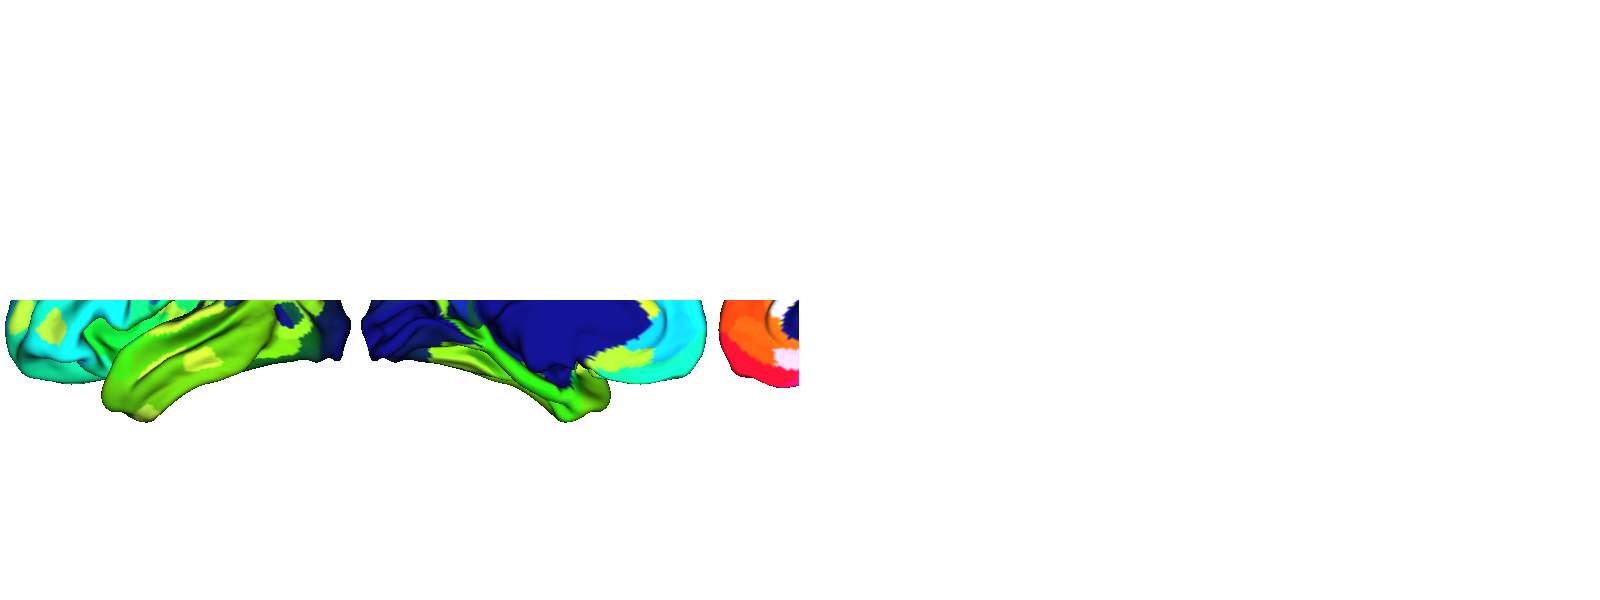

In [5]:
plot_hemispheres(surf_lh, surf_rh, array_name=Glasser, size=(800, 300),
                 cmap='gist_ncar', zoom=1.25, color_bar=True, embed_nb=True, interactive=False)

## 3. Mask of the medial wall

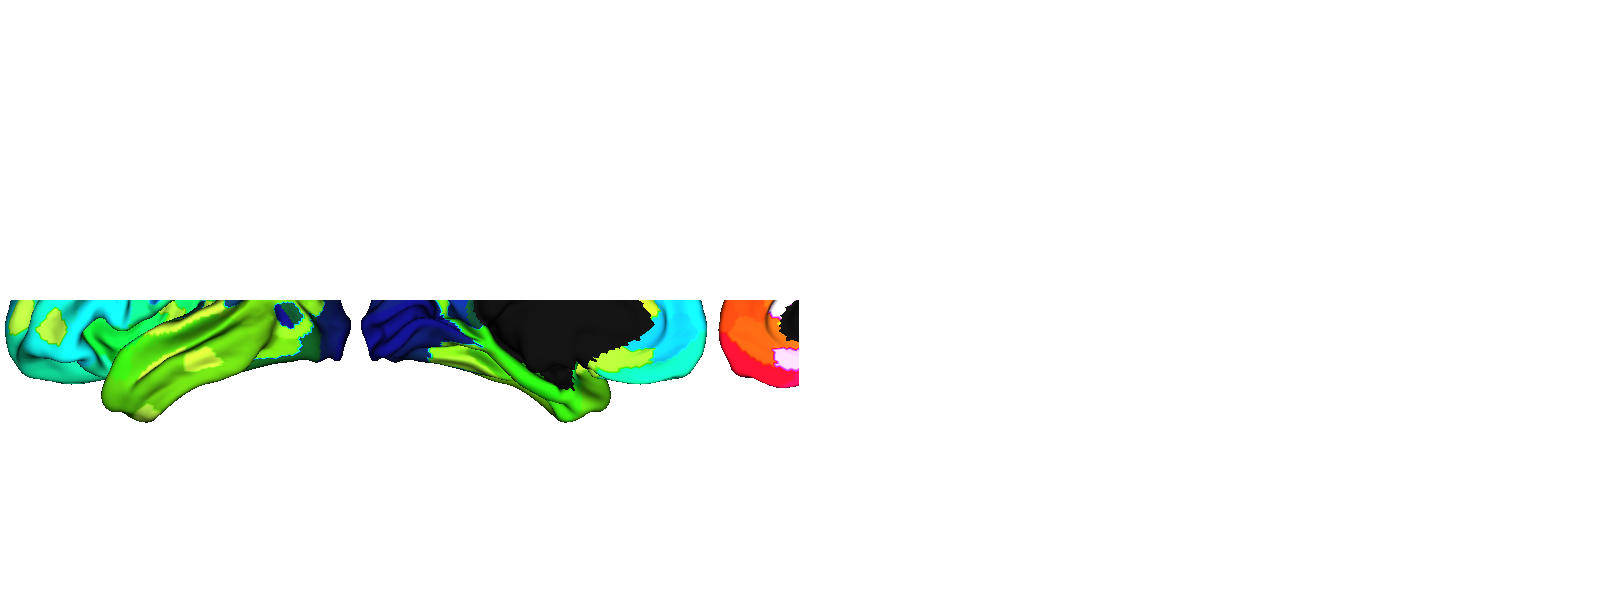

In [6]:
# Mask the 0-value ROI of the medial wall
mask = Glasser != 0

# Create an array of the ROI unique values (Nrois x 1, float)
GlasserROIs = np.asarray(np.unique(Glasser), dtype=float)

# Map ROI values to vertices indexes (Nvertices x 1)
Glasser_masked = map_to_labels(GlasserROIs, Glasser, mask=mask, fill=np.nan)

# Plot ROIs with masked medial wall
plot_hemispheres(surf_lh, surf_rh, array_name=Glasser_masked, size=(800, 300), nan_color=(0, 0, 0, 1),
                 cmap='gist_ncar', zoom=1.25, color_bar=True, embed_nb=True, interactive=False)

## 4. ROI of Primary Motor Cortex for QC
> Area description: **Primary Motor Cortex (PMC)**  
Name of ROI: **4**  
Parcel Index: Right=**8**, Left=**8+180**  

First lets index a specific ROI from the vertices variable `Glasser`. Using a conditional operator we can obtain the ROI of interest.

/opt/anaconda3/lib/python3.7/site-packages/brainspace-0.1.1-py3.7.egg/brainspace/vtk_interface/wrappers/data_object.py:166: UserWarning: Input array is boolean. Casting to uint8.
  warnings.warn('Input array is boolean. Casting to uint8.')


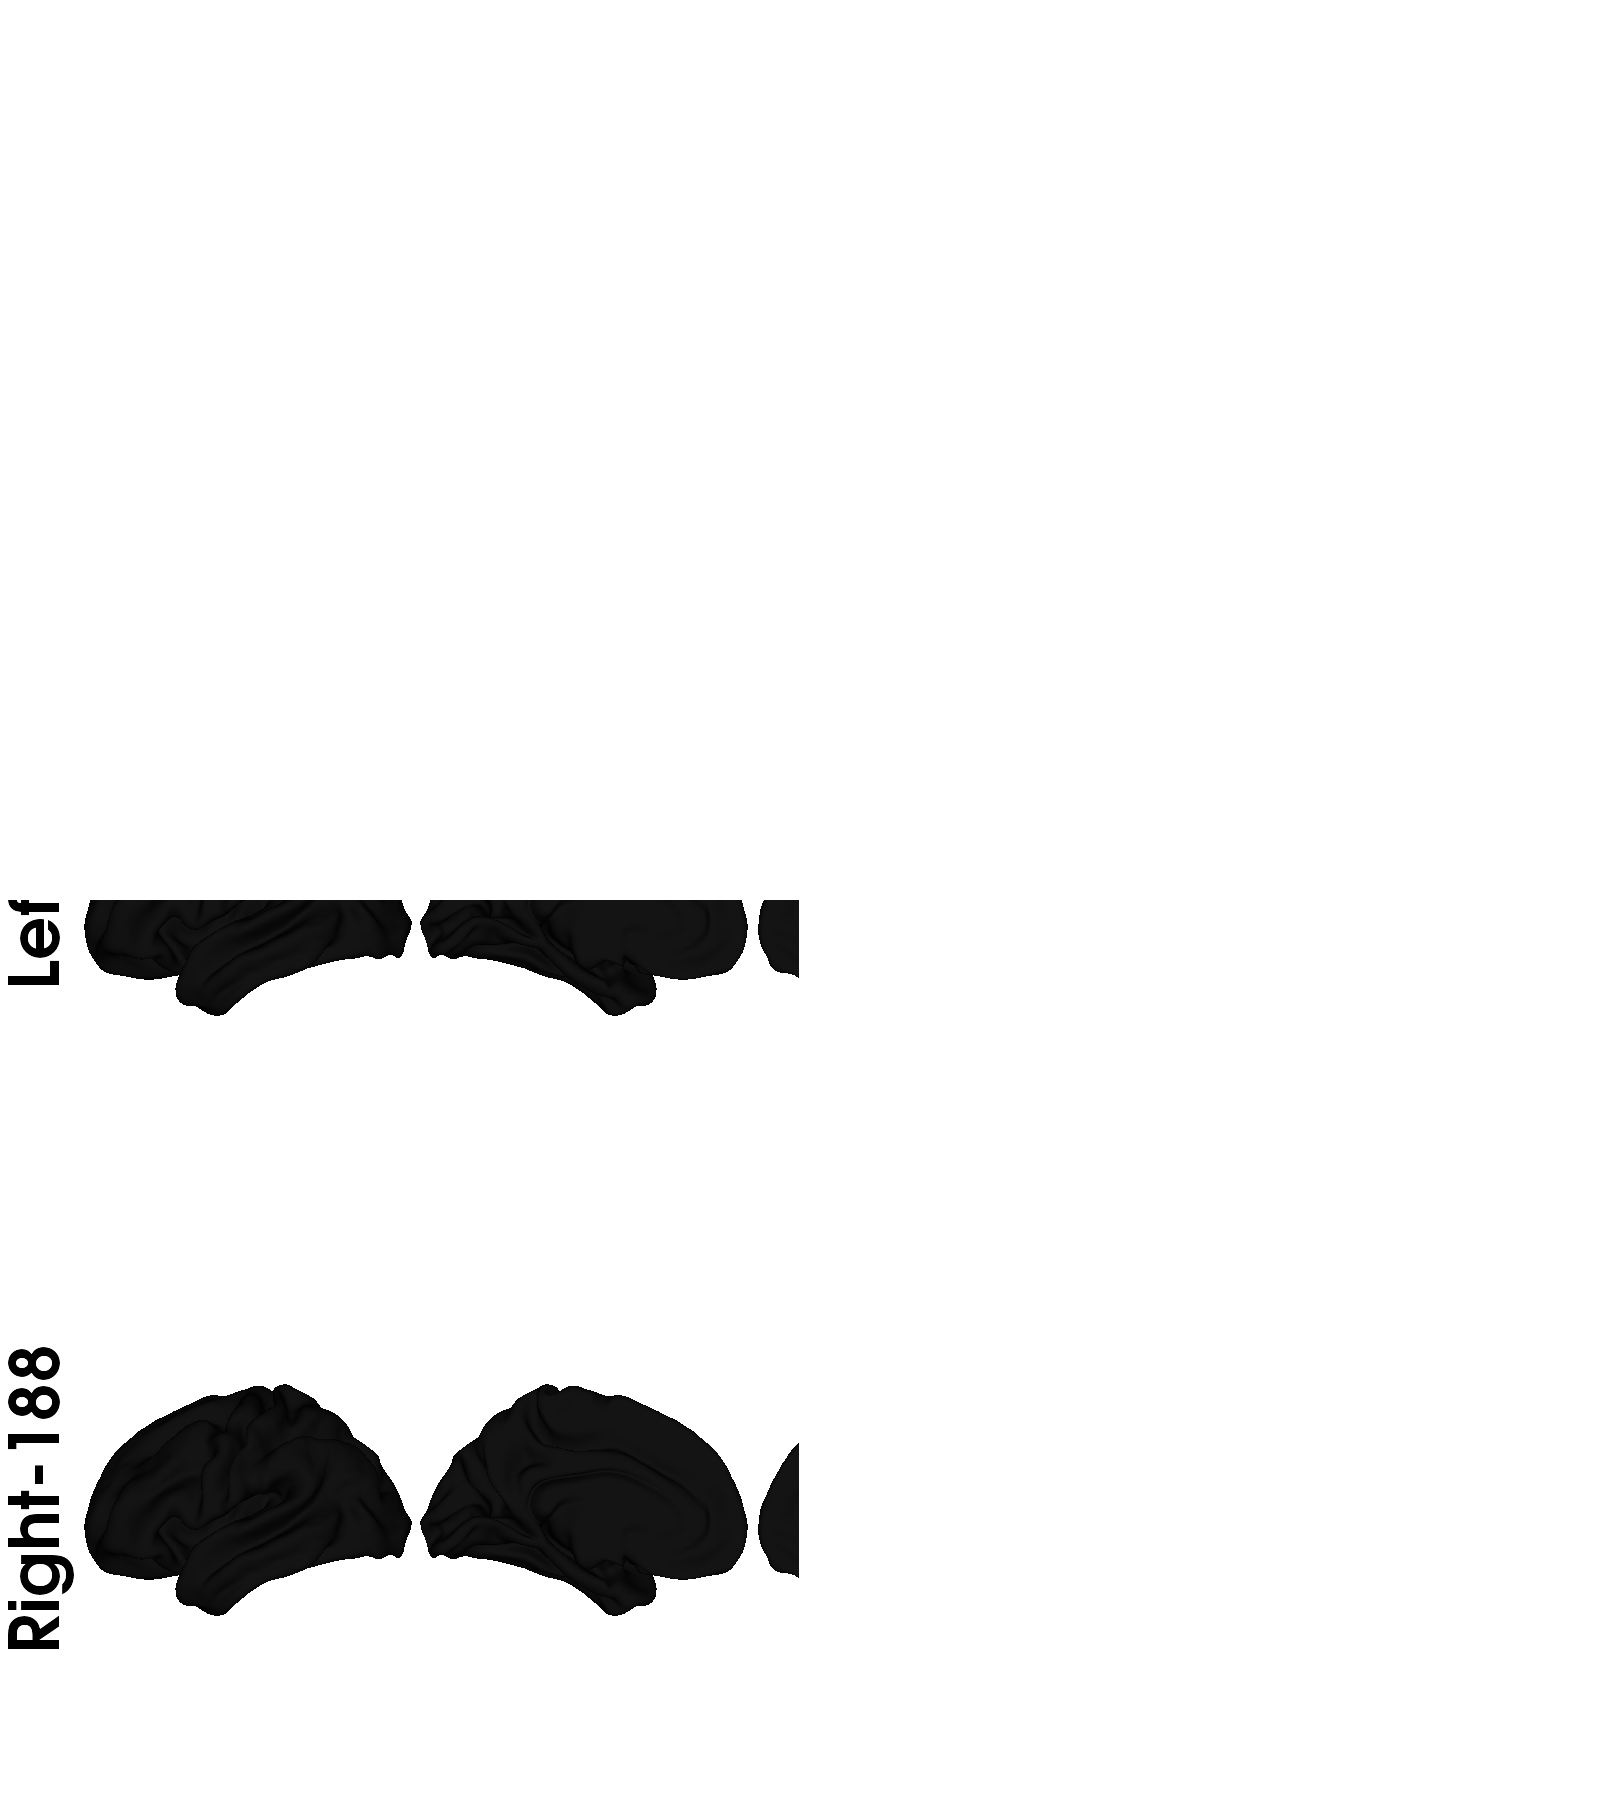

In [7]:
# Plot of an array of surfaces
ROI = 8  # ROI that we want to plot
PMC_labels = ['Bilateral PMC', 'Left-4', 'Right-188'] # Labels for each surface plot

# Create an list with the arrays of surfaces
PMCrois = [None] * 3

# Use conditional operator to find the ROI of interest
PMCrois[0]  = np.where((Glasser == ROI) | (Glasser == ROI+180), 1, 0)
PMCrois[1] = Glasser == ROI
PMCrois[2] = Glasser == ROI+180 # ROI+180 is the right ROI

# Plot of the array
plot_hemispheres(surf_lh, surf_rh, array_name=PMCrois, size=(800, 300*3),label_text=PMC_labels,
                 cmap='copper', zoom=1.25, color_bar=True, embed_nb=True, interactive=False)

## Function to plot unique ROIs
In this section we use the built-in function `map_to_labels` instead of the conditional operator to plot the ROI of interest. 

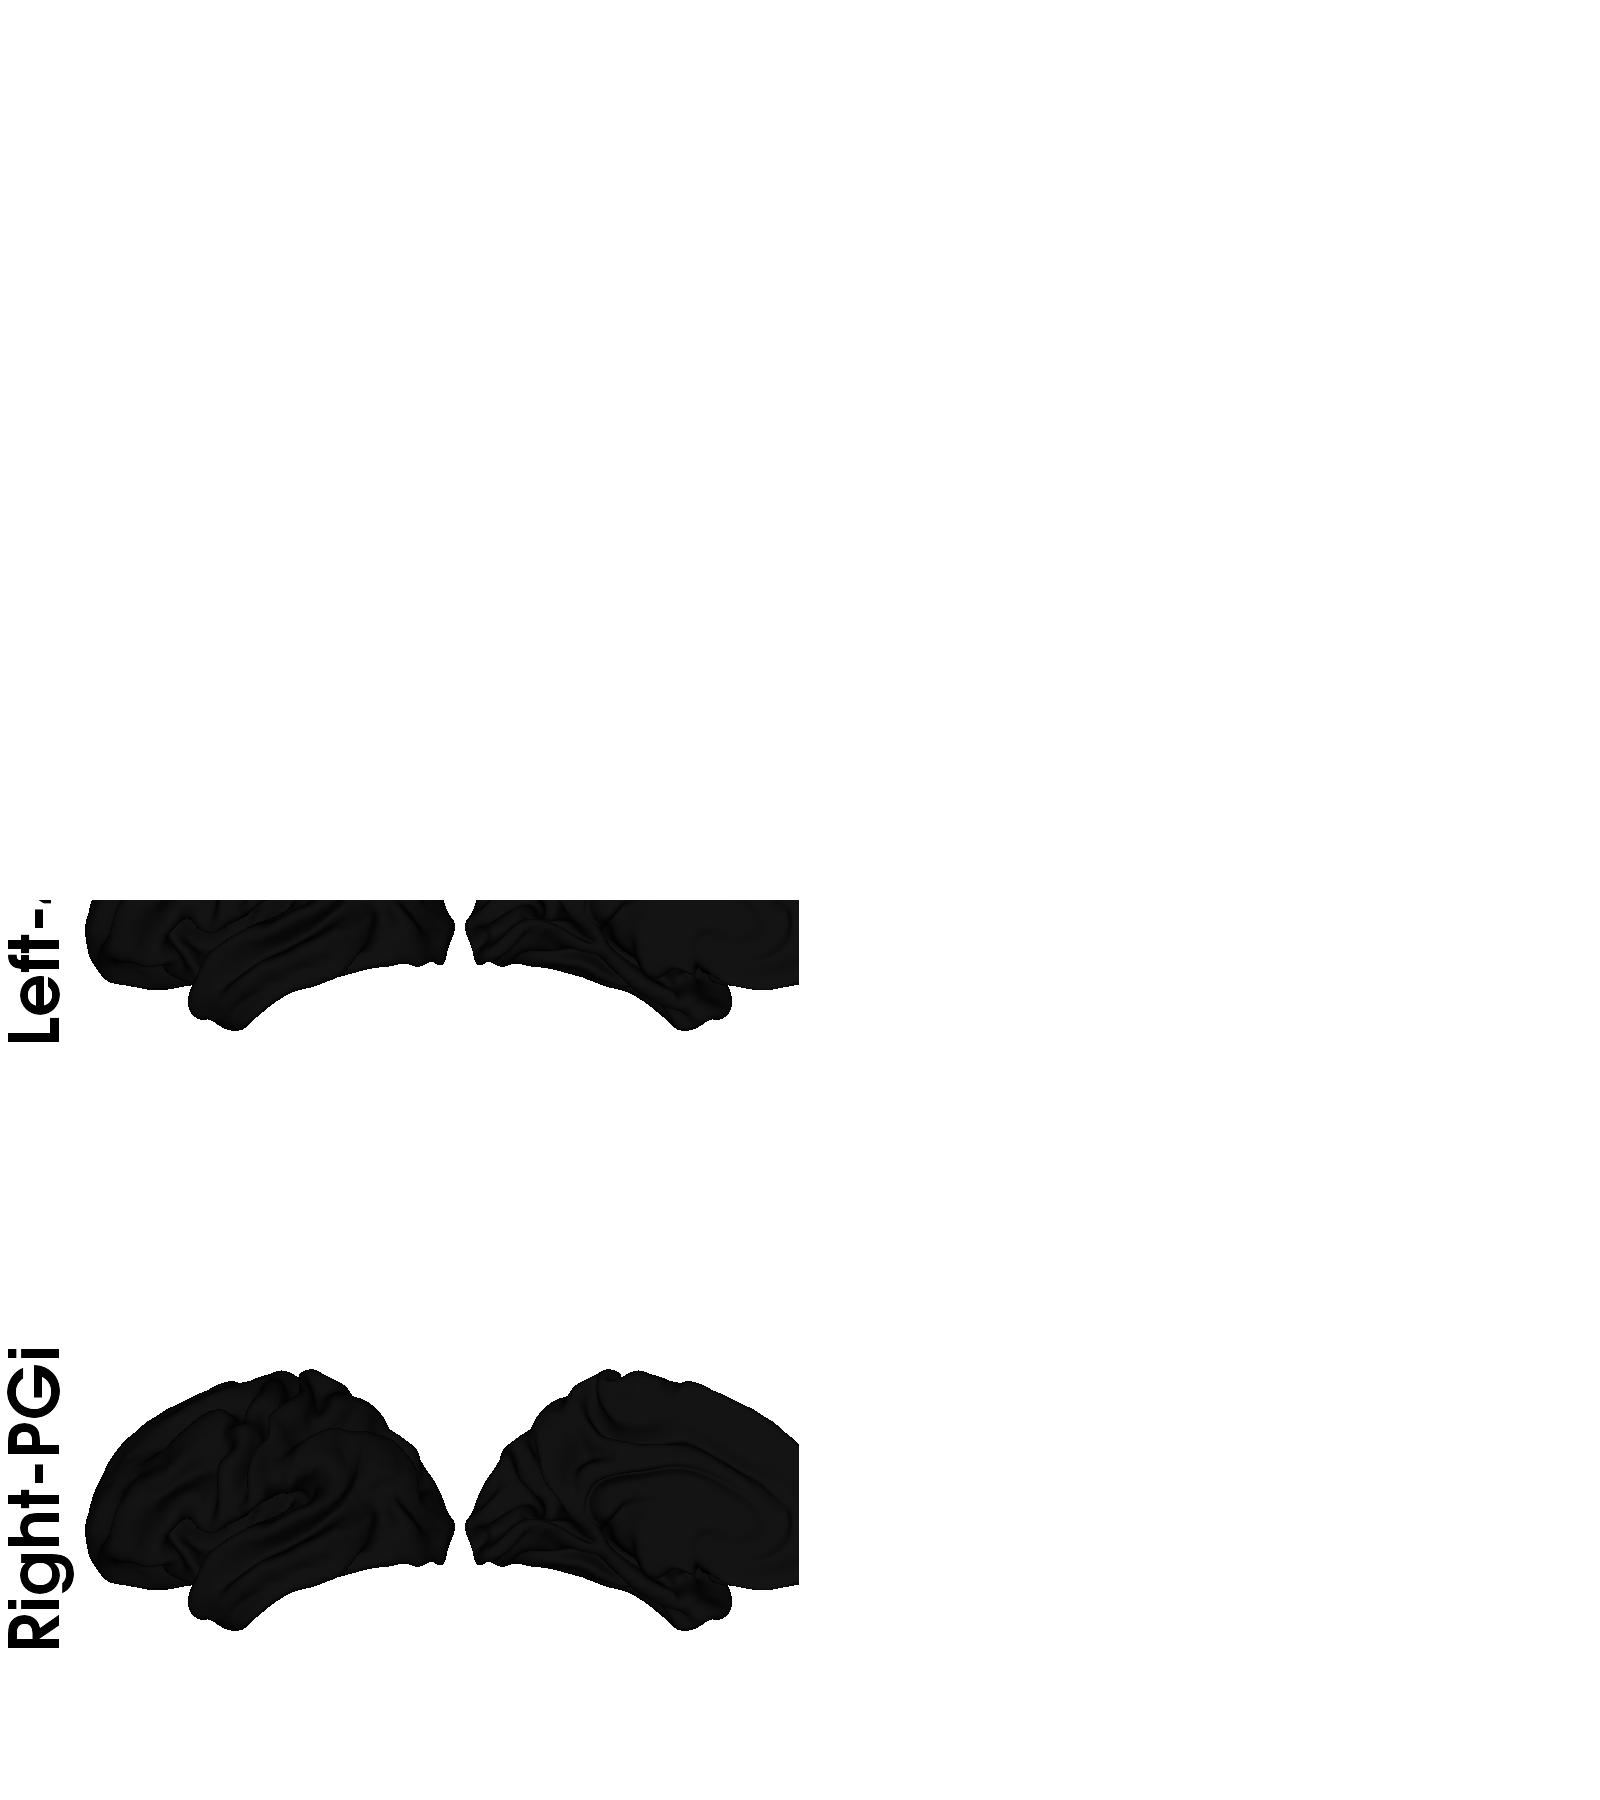

In [8]:
# @title function to plot unique ROI
def plot_glasser_ROI(ROI=8):
    """Plot the surface of a given ROI/indx of the Glasser parcellation.
    Args
    ----
        region_name_or_index (str or int): the short region name, or its index
    Returns
    -------
    figure : Ipython Image or panel or None
        Figure to plot. None if using vtk for rendering (i.e.,
        ``embed_nb == False``).
    """
    # Get the name and index of a given ROI
    roi, ind, name = hcpRegions.index(ROI)
    
    # Get the labels
    ROIs_labels = [name, 'Left-4'+roi, 'Right-'+roi] # Labels for each surface plot
    # Slice ROI
    GlasserROIs = np.asarray(np.unique(Glasser), dtype=int)
    
    # Create an list with the arrays of surfaces
    Conditionals = [(GlasserROIs == ind) | (GlasserROIs == ind+180), GlasserROIs == ind, GlasserROIs == ind+180]
    ROIs = [None] * 3

        # Map value to surface with medial wall mask
    for i in range(0,3):
        ROIvec = np.where(Conditionals[i], 1, 0)
        ROIs[i]  = map_to_labels(np.asarray(ROIvec, dtype=float), Glasser, mask=mask, fill=np.nan)
    
    # Plot of the array
    return plot_hemispheres(surf_lh, surf_rh, array_name=ROIs, size=(800, 300*3),label_text=ROIs_labels,
                     cmap='copper', zoom=1.25, color_bar=None, embed_nb=True, interactive=False)

# Plot an explample using the function
plot_glasser_ROI('PGi')  

## Plot a vector of values to the surface

In [9]:
# Create an array with random values from -1 to 1
# add a 0 entry that will match the medial wall index of the final array
rho_rand = np.concatenate((0, np.random.uniform(-1,1,[360,1])), axis=None)

# Map the vector values to the vertices indices
rho_ver = map_to_labels(rho_rand, Glasser, mask=mask,fill=np.nan)

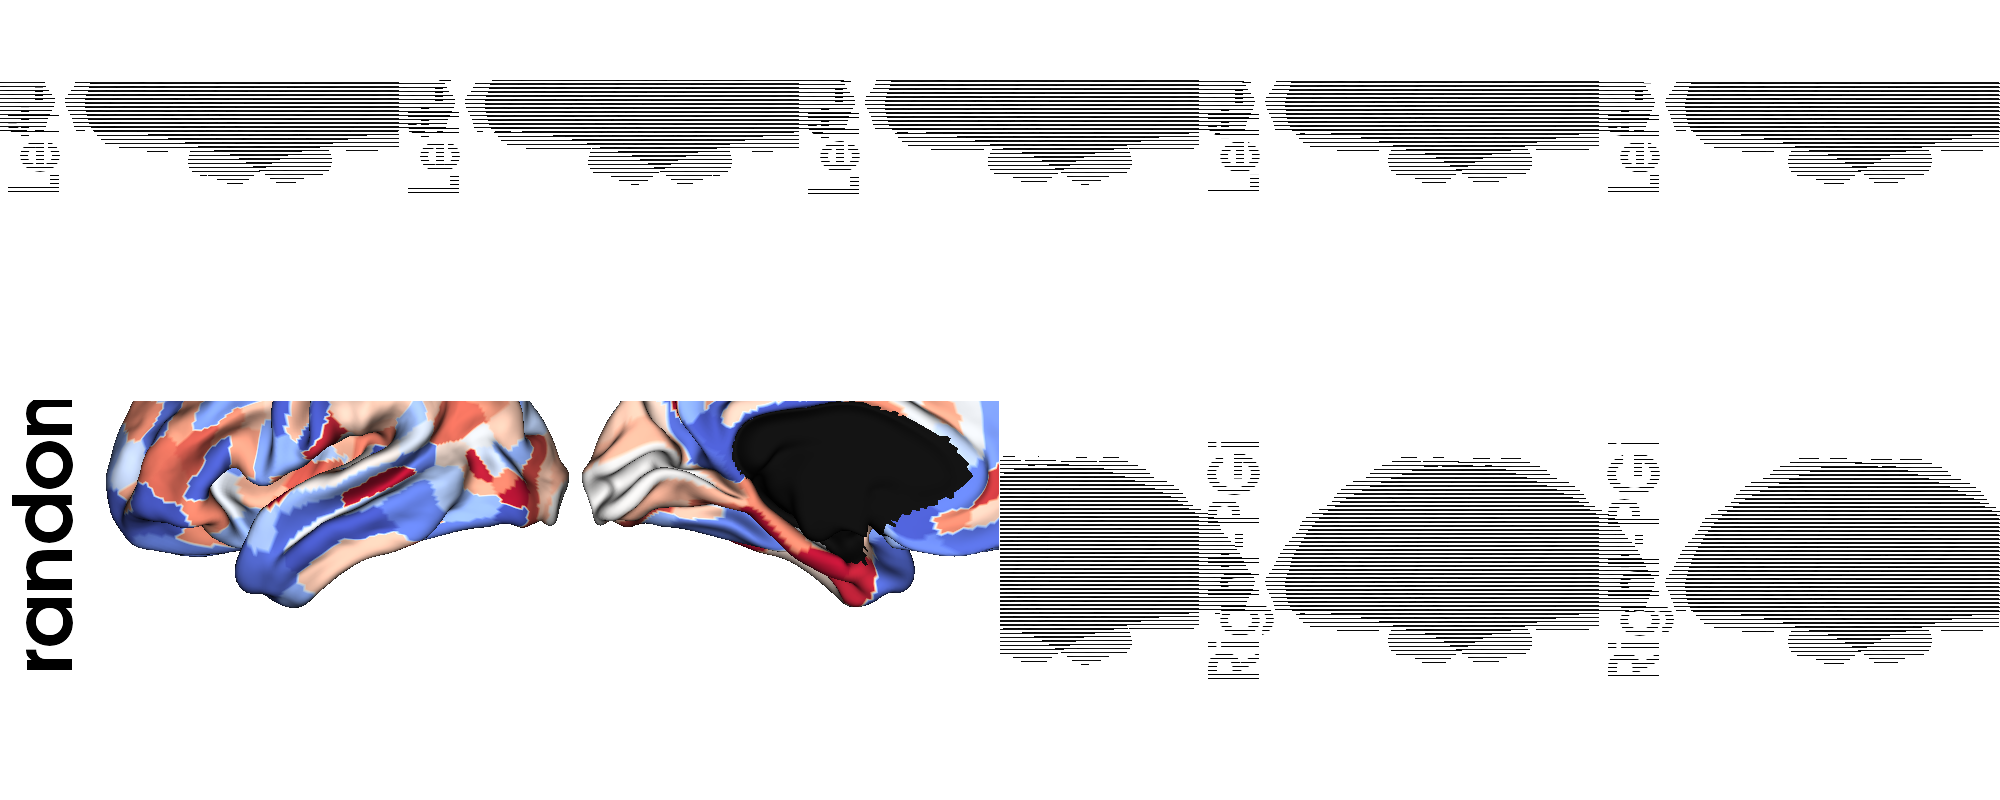

In [10]:
# Plot random Rho values over the surface
Lim = (-0.9, 0.9)
plot_hemispheres(surf_lh, surf_rh,      # Surfaces
                 array_name=rho_ver,    # Vector of alues to plot
                 size=(1000, 400),       # Size of the output figure
                 label_text={'left':['random rho']}, # Text and position
                 color_bar='top',       # Position of the colorbar
                 cmap='coolwarm',       # COlormap from matplotlib
                 zoom=1.25,             # zoom on the surface
                 embed_nb=True,         # Embeded this ins inline plot
                 interactive=False,     # Pop-up plot, for embed_nb=True default is False
                 share='both',          # match to colormap on rows and columns
                 color_range=Lim,       # color range
                 nan_color=(0, 0, 0, 1), # nan-color (medial wall) default black
                 background = (1, 1, 1) # Background color, default is white
                )

## Customize a colormap  
You can change the colormap with the `plot_hemispheres` argument `cmap`. All the colormaps from [matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) are avaliable!.

In [11]:
# Get the colormap function with cm
winter = cm.get_cmap('winter')
cool = cm.get_cmap('cool')

# Create a new colormap merging winter and cool with 0 set to gray
newcolors = np.full((256, 4), [0.5, 0.5, 0.5, 1]) # New colormap with gray color default (shape=256x4)
newcolors[0:int((256/2)), :] = cool(np.linspace(0, 1, int((256/2))))
newcolors[int((256/2)):, :] = winter(np.linspace(0, 1, int((256/2))))

# np.array to colormap
my_colormap = ListedColormap(newcolors)

### Surface plots varying colormaps and color bar position

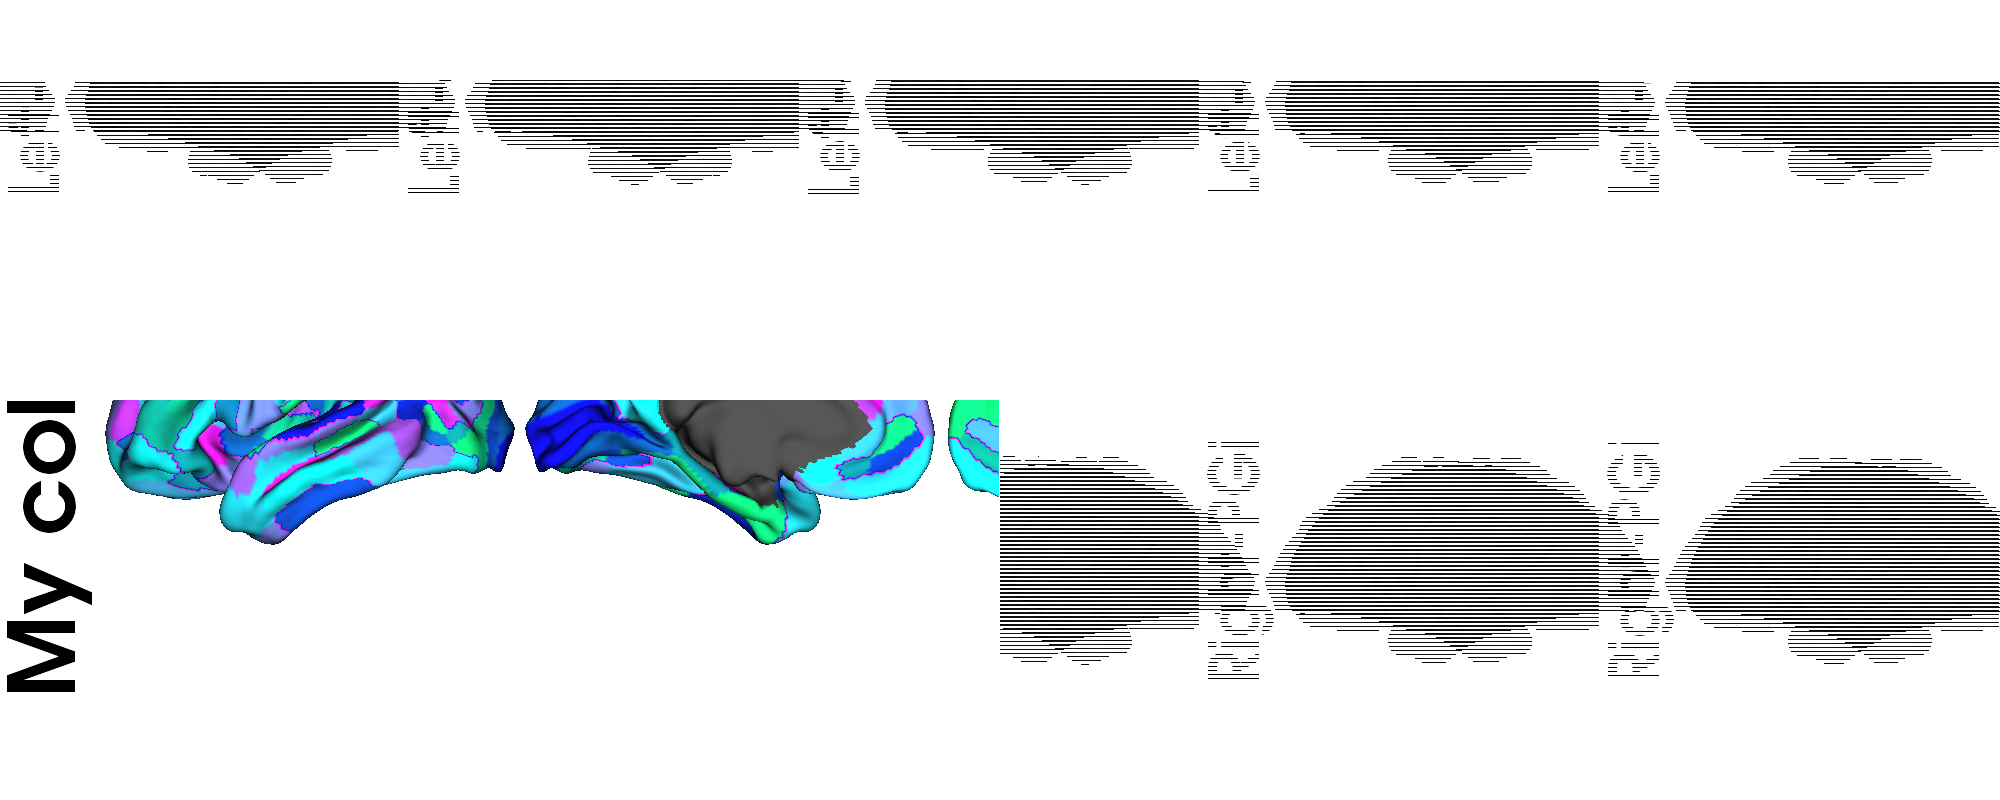

In [12]:
#@title Color bar= Right, Color map = my_colormap, zoom=1.5
Nan_col = (0.25, 0.25, 0.25, 1) # Color for the medial wall

# plot surface
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['My colormap']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='right', cmap=my_colormap, zoom=1.25, color_range=Lim
                )

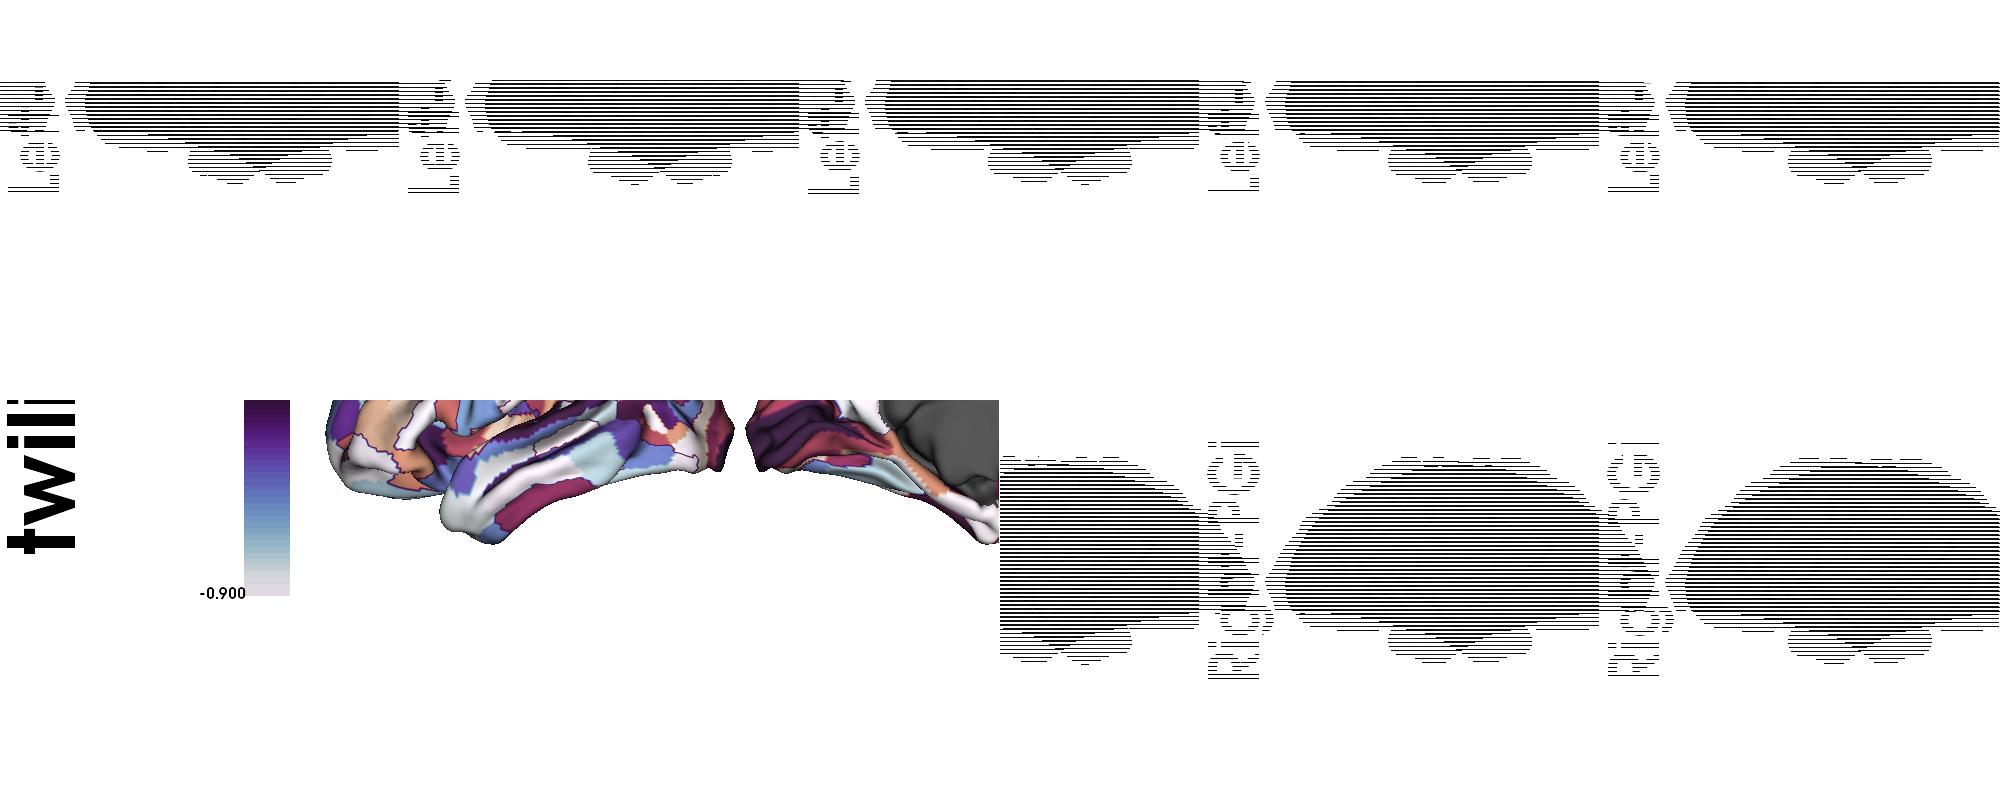

In [13]:
#@title Color bar= left, Color map = twilight, zoom=1.5
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['twilight']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='left', cmap='twilight', zoom=1.25, color_range=Lim
                )

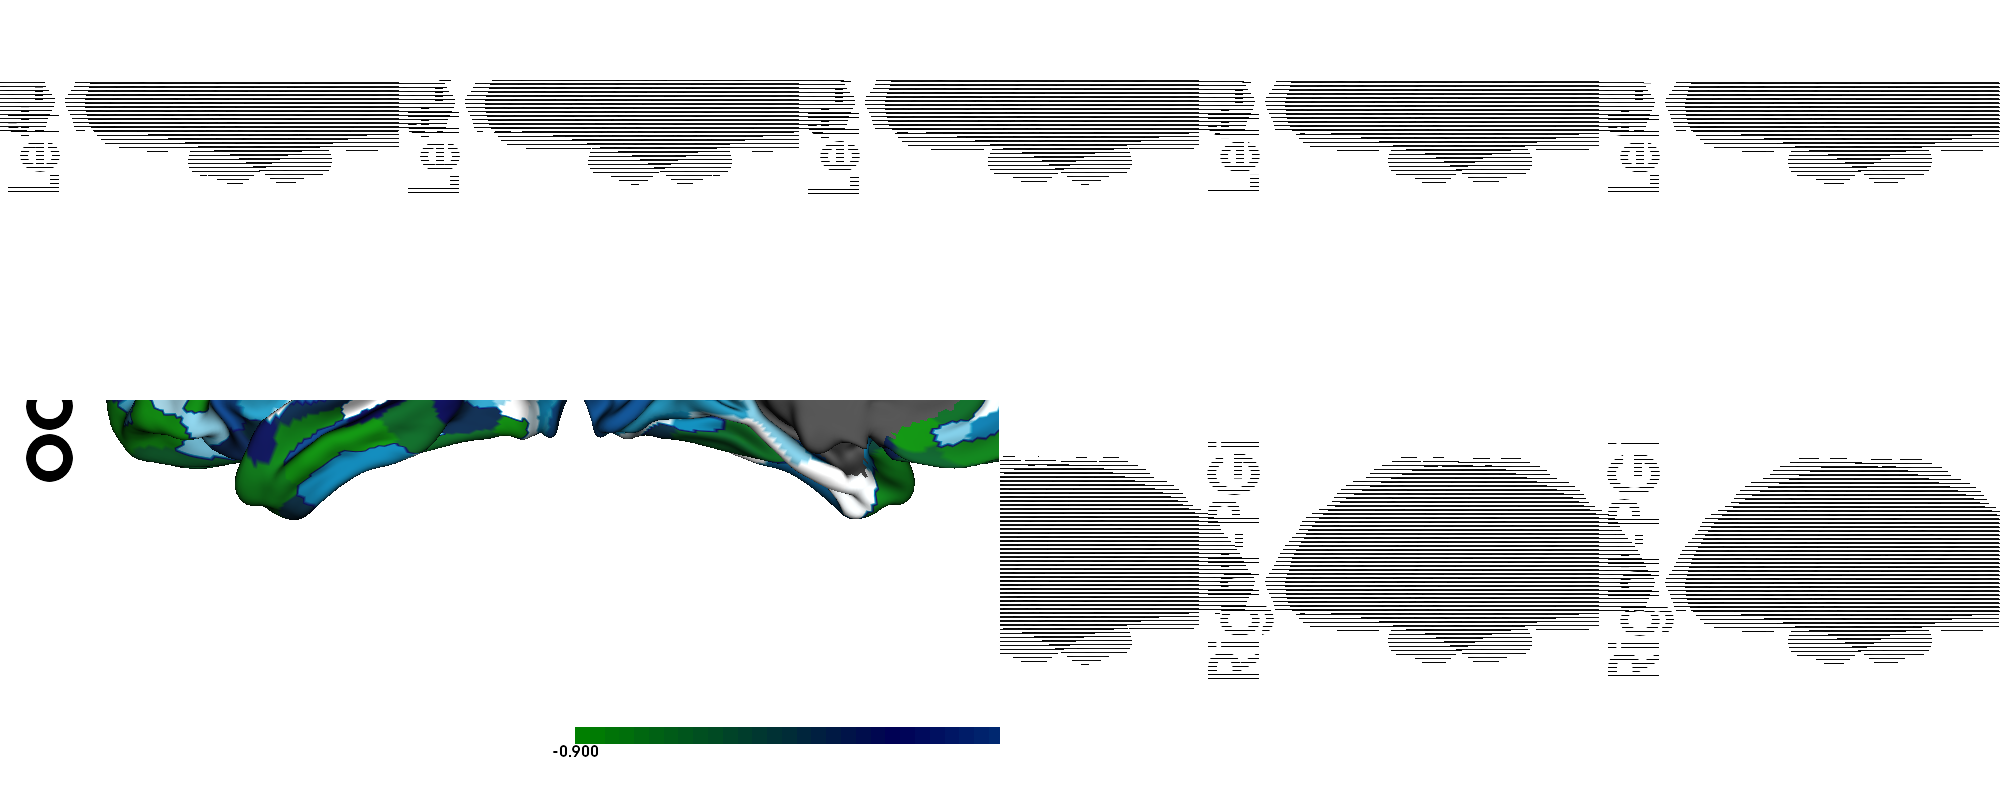

In [14]:
#@title Color bar= bottom, Color map = ocean, zoom=1.5
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['ocean']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='bottom', cmap='ocean', zoom=1.25, color_range=Lim
                )

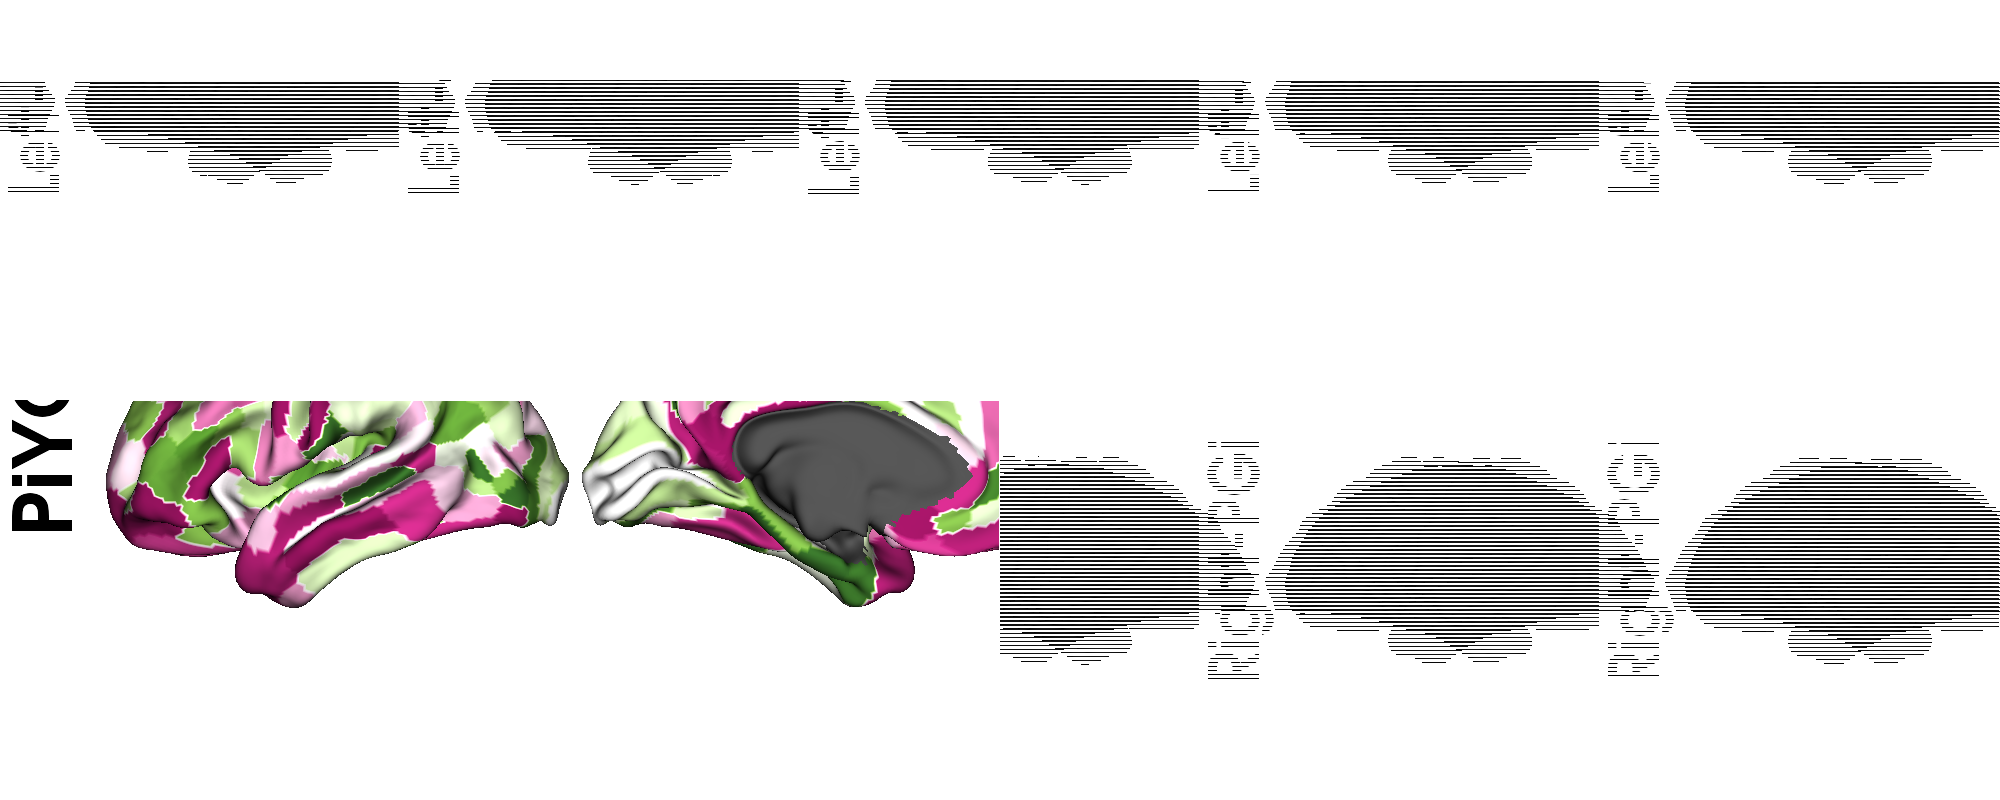

In [15]:
#@title Color bar= top, Color map = PiYG, zoom=1.5
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['PiYG']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='top', cmap='PiYG', zoom=1.25, color_range=Lim
                )

## Changing the color range could be helful to visualize some features better

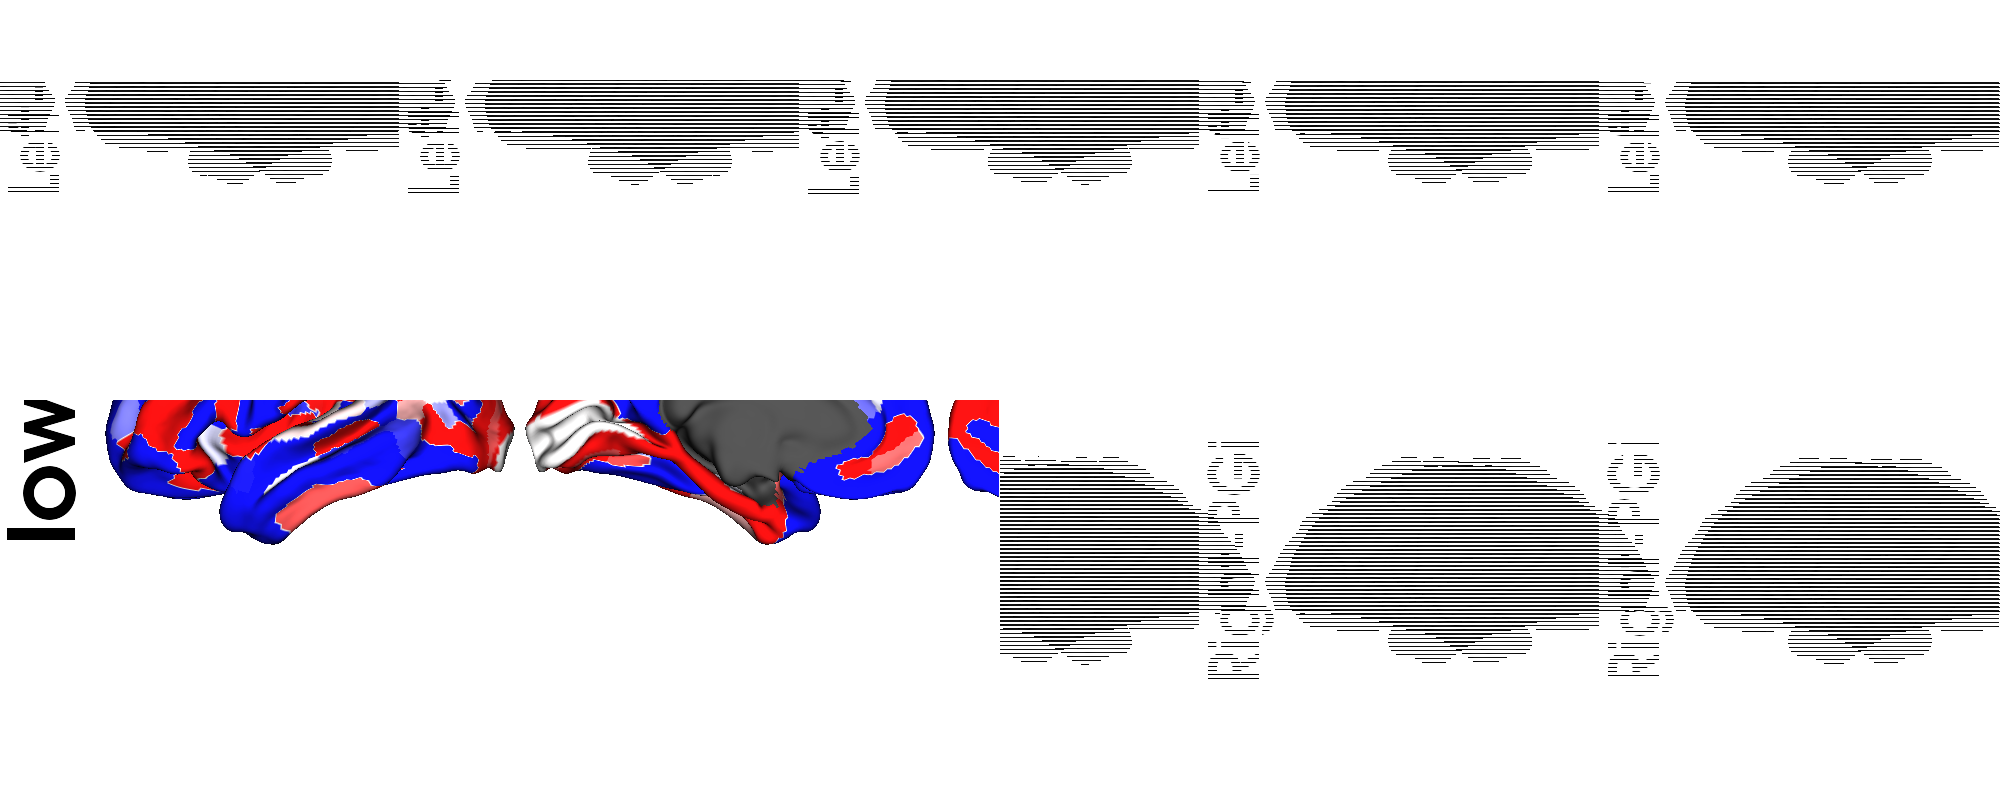

In [16]:
#@title Low threshold, range=(-0.35, 0.35)
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['low thr']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='right', cmap='bwr', zoom=1.25, color_range=(-0.35, 0.35)
                )

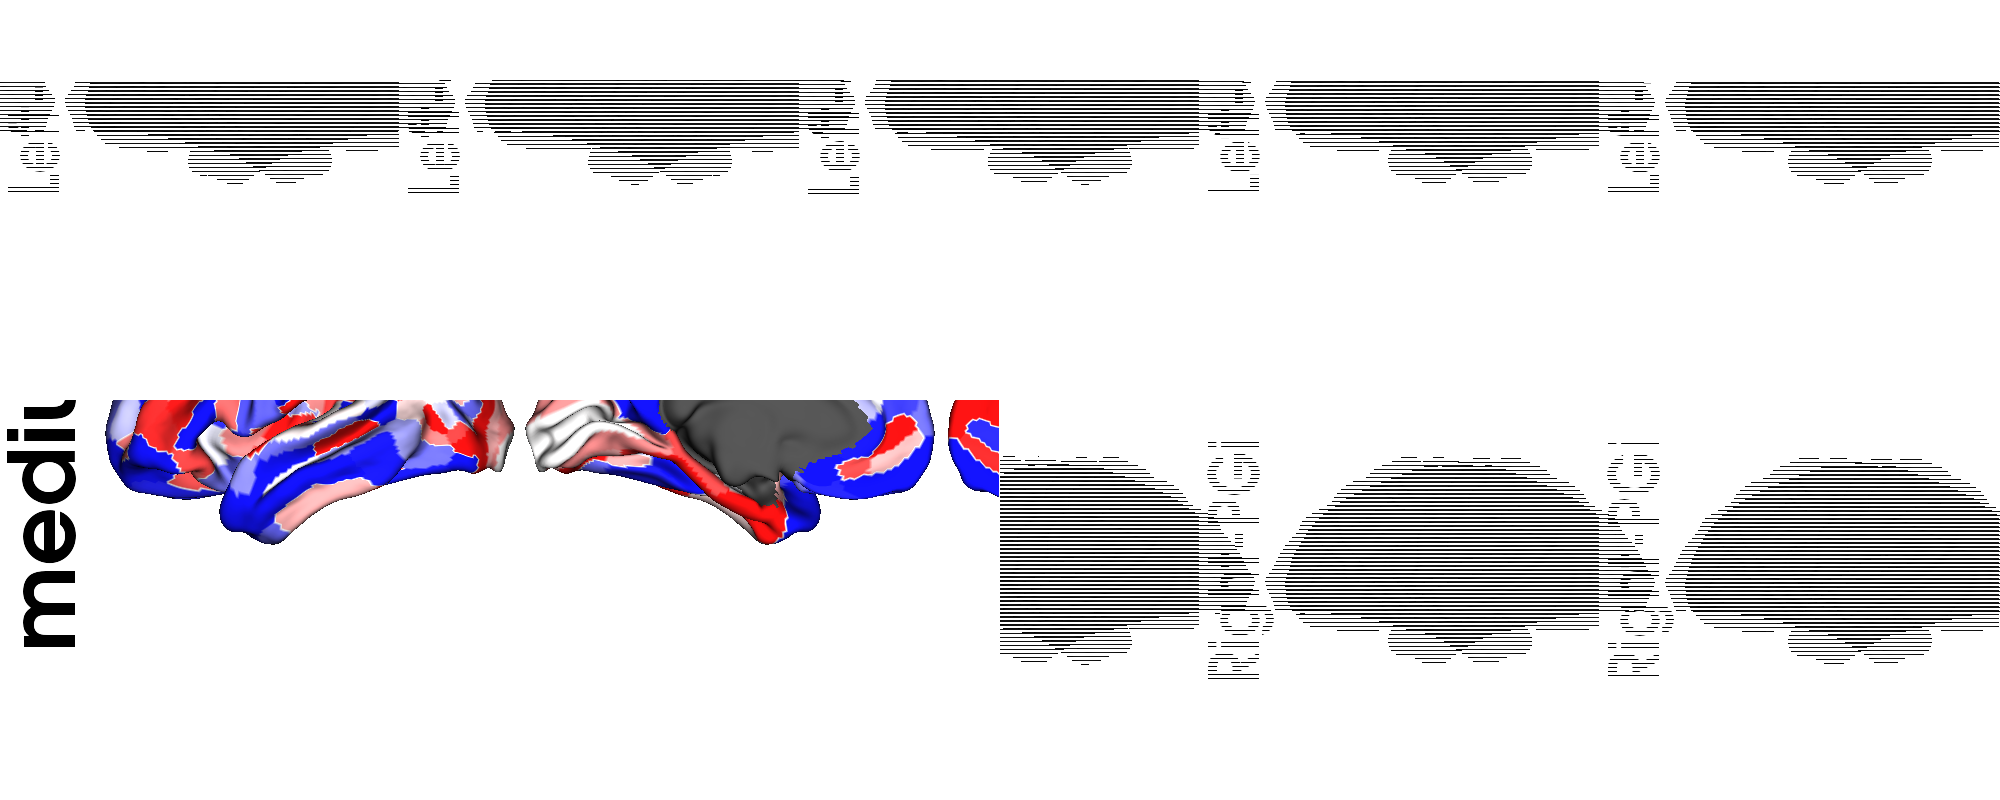

In [17]:
#@title Medium threshold, range=(-0.75, 0.75)
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['medium thr']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='right', cmap='bwr', zoom=1.25, color_range=(-0.75, 0.75)
                )

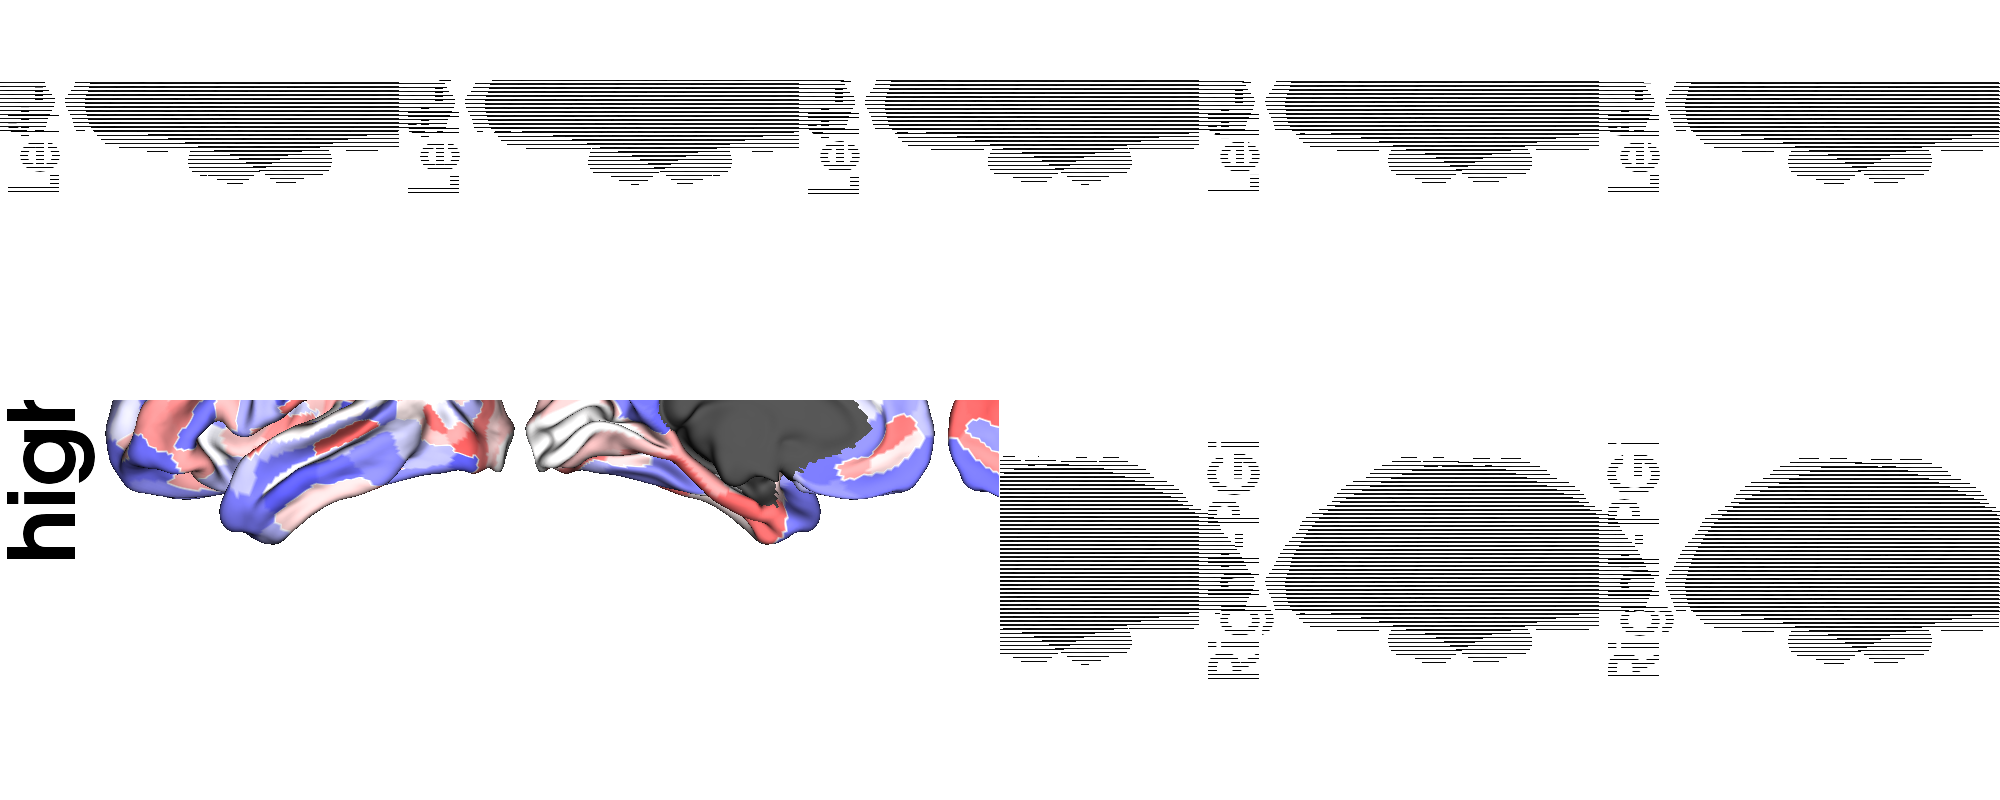

In [18]:
#@title High threshold, range=(-1.5, 1.5)
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['high thr']},
                 embed_nb=True, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='right', cmap='bwr', zoom=1.25, color_range=(-1.5, 1.5)
                )

# Pop-up interactive plot
There is an iteractive option for the surface plot, by setting `embed_nb=False` and `interactive=True` a pop-up window will appear!


In [19]:
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(2000, 500), label_text={'left':['Good to publish']},
                 share='both', nan_color=Nan_col,
                 color_bar='right', cmap='PuOr', zoom=1.25, color_range=(-1.5, 1.5),
                 embed_nb=False, 
                 interactive=True,
                 background = (0, 0, 0) # Set background black
                )

# Pop-up widget - All ROI from Glasser
Thanks to [davi1990](https://github.com/davi1990) for making this widget work as a pop-up plot.

In [20]:
def refresh(ROI=8):
    # ROI that we want to plot
    ROI = ROI
    # Get the name and index of a given ROI
    roi, ind, name = hcpRegions.index(ROI)
    # ROI information
    hcpRegions.what_is(ROI, verbose=True)
    # Get the labels
    ROIs_labels = [name, 'Left-4'+roi, 'Right-'+roi] # Labels for each surface plot

    # Create an list with the arrays of surfaces
    surfArray = [None] * 3

    # Use conditional operator to find the ROI of interest
    surfArray[0]  = np.where((Glasser == ind) | (Glasser == ind+180), 1, 0)
    surfArray[1] = Glasser == ind
    surfArray[2] = Glasser == ind+180 # ind+180 is the right ind

    #Plot of the array
    plot_hemispheres(surf_lh, surf_rh, array_name=surfArray, size=(800, 300*3),label_text=ROIs_labels,
                    cmap='magma', zoom=1.25, color_bar=None, embed_nb=False, interactive=True)
    

style = {'description_width': 'initial'}

_ = widgets.interact(refresh, 
    ROI=hcpRegions.table["AreaName"],
)  



interactive(children=(Dropdown(description='ROI', options=('V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b…

# Screenshot of your plot
There is an optional feature to save your plot as a file with `screenshot = True`. However if this option is set, you should also define the file name and path `filename` and if you want a transparent background or not `transparent_bg = True | False`

In [23]:
plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 400), label_text={'left':['Good to publish']},
                 embed_nb=False, interactive=False, share='both', nan_color=Nan_col,
                 color_bar='right', cmap='PuOr', zoom=1.25, color_range=(-1.5, 1.5),
                 screenshot = True,       # Save the plot
                 transparent_bg = True,   # background for screenshot, default if False
                 filename = '/Users/rcruces/Desktop/my_plot_to_publish.png' # Filename to save the screenshot, default is None
                )

'/Users/rcruces/Desktop/my_plot_to_publish.png'

# Section under development, wait for the release of brainspace 0.2.0!!
## Surface clustering

In [151]:
# mesh_cluster(surf_lh, n_clusters=10, mask=mask, approach='ward')

## More settings for surface plotting with **plot_surf**  
### More the layout (2 x 2, 1 x 2, 3 x 3)
### New views {superior, inferior, anterior and posterior}

In [27]:
# Ditionary with the surfaces
surfs = {'lh': surf_lh, 'rh': surf_rh}
# Plot Layout (shape = (n_rows, n_cols))
layout = np.array([['lh', 'lh'], ['rh', 'rh']])
view = [['lateral', 'medial'], ['lateral', 'medial']]
kwds = {'share': 'r'}
# array_name revisar plot_hemispheres
# array_name = [['a', 'b'], ['c', 'd']]
# surf_lh.append_array(my_rho, name='a', at = 'p')
plot_surf(surfs, layout, array_name=rho_ver, view=view, color_bar='bottom',
              color_range='Sym', share=False, label_text='rho', cmap='twilight',
              nan_color=(0, 0, 0, 1), zoom=1, background=(1, 1, 1),
              size=(400, 400), embed_nb=True, interactive=False, scale=(1, 1),
              transparent_bg=True, screenshot=False, filename=None,
              return_plotter=True)

# background=(1, 1, 1) background es de 0 a 1 si es de 1/256

ValueError: Cannot broadcast 'array_name' with shape (64984,) to shape (2, 2)